# CNN Flower Classification

**Create 2 CNN models to classify flowers**  
**One using a custom model, and one using transfer learning from a pretrained keras model**  

*Author: [Andreas Svensson](https://github.com/Andreas-Svensson)*  
<br>
##### Dataset  
[Flowers Dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) from Kaggle  

Dataset information:   
Contains over 4000 images of 5 different types of flowers, around 800 images for each type  
Images are not a fixed size or aspect ratio, but are around 320x240 px in large  


Imports

In [1]:
import keras
from keras import layers
from keras.applications import MobileNet
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.utils import image_dataset_from_directory

import keras_tuner as kt

import visualkeras

import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.data.experimental import cardinality

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
from pathlib import Path
import os

# Data Cleaning

The original dataset is copied to flowers_cleaned to store the data changed during cleaning  
Define a function to display an image based on its name  

In [2]:
# dataset paths
original_data_path = Path("flowers_original") # original dataset
data_path = Path("flowers") # path to copy of original dataset

# function to show images
def show_image(file_name):
    for root, dirs, files in os.walk(original_data_path):
        if file_name in files:
            file_path =  os.path.join(root, file_name)
            image = Image.open(file_path)
            display(image)
            break

### What Data to Remove?

Images are removed from the original dataset due to them either not being flowers, being difficult to identify as flowers, or are classified as "outliers" i.e. very rare depictions of a flower that could hurt the performance of a model on more typical depictions of them  

Below are some examples of images that are removed from the original dataset:

Images Without Flowers

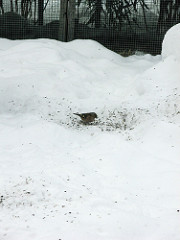

In [3]:
show_image("34733243845_29f1c30634_n.jpg")

Drawn Images

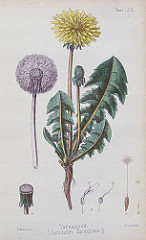

In [4]:
show_image("15268682367_5a4512b29f_m.jpg")

Images with heavy after-effects and editing

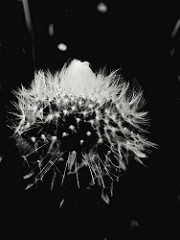

In [5]:
show_image("34700475225_fbc12d0834_n.jpg")

Images where flowers are too small to see clearly

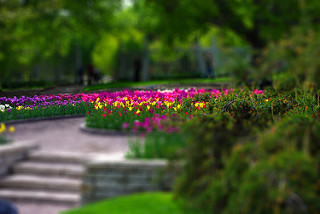

In [6]:
show_image("5043225469_0aa23f3c8f_n.jpg")

Images with multiple different types of flowers in them

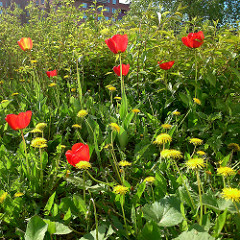

In [7]:
show_image("17688233756_21879104c1_n.jpg")

Blurry or out-of-focus images

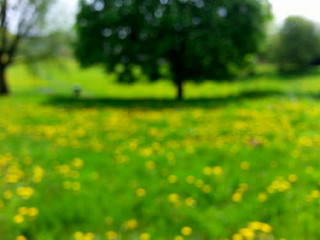

In [8]:
show_image("14648777167_1d92d403c9_n.jpg")

Wilted or very broken flowers

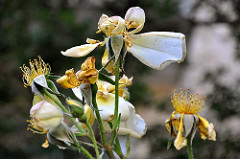

In [9]:
show_image("5002458392_f465ed905e_n.jpg")

Otherwise images where a human would have a hard time classifying the flower

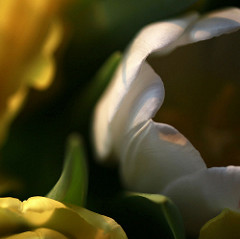

In [10]:
show_image("5388013398_09a8a0f166_m.jpg")

## Images Removed

Amount of images removed after following above rules and going through the entire dataset

In [11]:
original = sum(1 for _ in original_data_path.rglob("*") if _.is_file())
cleaned = sum(1 for _ in data_path.rglob("*") if _.is_file())

print(f"{original - cleaned}/{original} images removed from data cleaning")

327/4317 images removed from data cleaning


# Data Analysis

Load the cleaned data to a DataFrame for some analysis

In [12]:
# initialize dataframe
df = pd.DataFrame(columns=["width", "height", "class", "filename"])

# iterate over images dataset subfolders
for image_path in data_path.rglob("*/*"):
    with Image.open(image_path) as img: # open image
        width, height = img.size # get image dimensions
    # add row to df containing:
    # width, height, subdir name (class) and file name
    df.loc[len(df)] = [width, height, image_path.parts[-2], image_path.parts[-1]]

df.head()

,width,height,class,filename
0,320,263,daisy,100080576_f52e8ee070_n.jpg
1,500,313,daisy,10140303196_b88d3d6cec.jpg
2,320,215,daisy,10172379554_b296050f82_n.jpg
3,500,333,daisy,10172567486_2748826a8b.jpg
4,320,250,daisy,10172636503_21bededa75_n.jpg


## Dataset Balance
Class balance is relatively even, there is some difference but no class is greatly over- or under-represented

In [13]:
df["class"].value_counts()

class
dandelion    990
tulip        891
rose         727
daisy        701
sunflower    681
Name: count, dtype: int64

## Image Size

Looking at values, the width and height of images varies a lot  
This could potentially be a problem when rescaling images, as they could lose their aspect ratio and become stretched  
It could also be a problem if the input image size is much larger than some images, as they would become very blurry when scaling up  
As such, it would be beneficial to find a size close to the lower bound of image sizes to use as input size, this will also speed up the model  

In [14]:
df.describe().T.astype(int)

,count,mean,std,min,25%,50%,75%,max
width,3990,339,117,134,240,320,500,1024
height,3990,253,61,80,215,240,327,442


Closer look at size distribution, it would seem like the lower bound is somewhere around 125-150

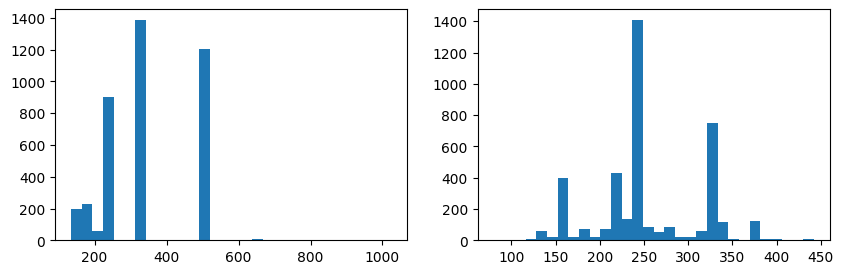

In [15]:
plt.figure(figsize=(10, 3))

for i, col in enumerate(["width", "height"]):
    plt.subplot(1, 2, i+1)
    plt.hist(df[col], bins=30)

Setting image size to 128x128 px would be towards the lower bound of each class  
If it's large enough to still classify flowers it will also make the model a lot faster to run on small images  
As such, 128x128 px seems like a good size to start exploring with, if the model ends up underperforming this value can be changed

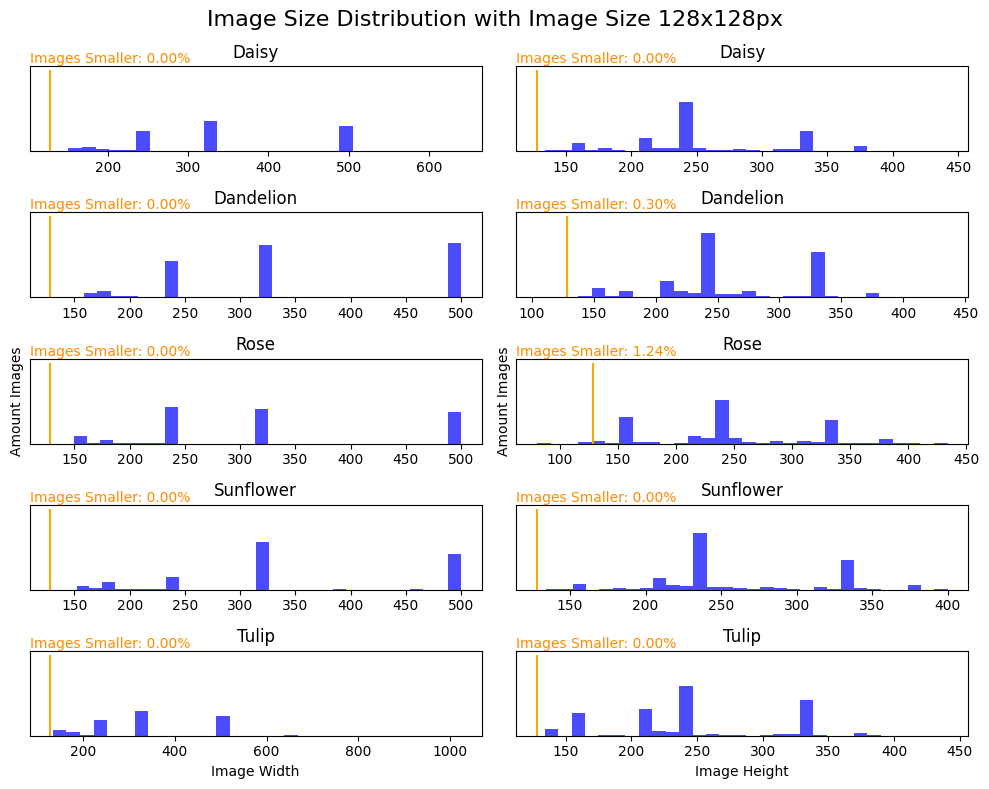

In [16]:
def classwise_histplot(df, image_size):
    def plot(data, cutoff):
        plt.hist(data, bins=30, color="blue", alpha=0.7)

        # add vertical line with text
        plt.vlines(cutoff, 0, max(data), colors="orange")
        amount_removed = sum(1 for x in data if x < cutoff)
        plt.text(
            plt.xlim()[0],
            plt.ylim()[1],
            f"Images Smaller: {amount_removed/len(data)*100:.2f}%",
            verticalalignment="bottom",
            horizontalalignment="left",
            color="darkorange"
        )
        plt.yticks([]) # hide y-ticks


    image_size = 128

    # iterate over list of classes and plot distribution of image width/height for each class
    classes = df["class"].unique()
    plt.figure(figsize=(10, 8))
    for i, class_name in zip(range(1, len(classes)*2+1, 2), classes):
        for count, col in enumerate(["width", "height"]):
            plt.subplot(5, 2, count+i) # select subplot to plot in
            data = df[df["class"] == class_name][col] # get subset of data to plot
            plot(data, image_size)
            plt.title(f"{class_name.capitalize()}")
            if i == len(classes):
                plt.ylabel("Amount Images")
            if i == len(classes)*2-1:
                plt.xlabel(f"Image {col.capitalize()}")

    plt.suptitle(f"Image Size Distribution with Image Size {image_size}x{image_size}px", size=16)
    plt.tight_layout()
    plt.show()

classwise_histplot(df, image_size=130)

# Build Dataset

## Train Val Split

Using image_dataset_from_directory to split files in dataset into training and validation sets  
This is done using the subset parameter and validation_split size  
Train dataset will take 70% of the dataset, and the remaining 30% goes to val  
Labels are inferred from subfolder names in the dataset  

Batch size is set to 32, this will be true throughout the notebook  
Larger batch sizes leads to faster training as back propagation is done less often, while also requiring a more powerful computer  
Interestingly, smaller batch sizes often lead to better model performance  
See for example [this](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU#results-of-small-vs.-large-batch-sizes-on-neural-network-training) test from Weights & Biases  

In [17]:
batch_size = 32
image_size = (128, 128) # using image size determined in data analysis

train_ds = image_dataset_from_directory(
  data_path,
  validation_split=0.3,
  subset="training",
  seed=42,
  image_size=image_size,
  crop_to_aspect_ratio = True,
  batch_size=batch_size
  )

val_ds = image_dataset_from_directory(
  data_path,
  validation_split=0.3,
  subset="validation",
  seed=42,
  image_size=image_size,
  crop_to_aspect_ratio = True,
  batch_size=batch_size
)

Found 3990 files belonging to 5 classes.
Using 2793 files for training.
Found 3990 files belonging to 5 classes.
Using 1197 files for validation.


## Val Test Split

Split the 30% val dataset into val and test  
1/3rd (10%) goes to the test dataset  
2/3rd (remaining 20%) goes to the val dataset  

In [18]:
# split non-training data into test and val
val_batches = cardinality(val_ds) # amount of batches
test_ds = val_ds.take((val_batches) // 3) # first third of batches towards test
val_ds = val_ds.skip((val_batches) // 3) # remainder towards val

## Final Dataset

Checking the dataset, we have 70/20/10 train/val/test split  
The 5 classes have been encoded properly

In [19]:
# ensure correct split by calculating percentages of datset in each subset
all = train_ds.cardinality() + val_ds.cardinality() + test_ds.cardinality() # total amt batches
percent_train = train_ds.cardinality() / all * 100
percent_val = val_ds.cardinality() / all * 100
percent_test = test_ds.cardinality() / all * 100

print(f"{percent_train:.0f}% Train, {percent_val:.0f}% Validation, {percent_test:.0f}% Test")

classes = train_ds.class_names
print("Class names:", ", ".join(classes))

70% Train, 21% Validation, 10% Test
Class names: daisy, dandelion, rose, sunflower, tulip


## Caching

Using AUTOTUNE to keep dataset in memory where possible  
Will speed up inference due to not having to read values every time

In [20]:
autotune = AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

# Data Augmentation

## Define Data Augmentation Layers

Creating a group of layers containing agumentation layers  
This group will be passed to the model to randomly (within the specified rangese) augment data as it passes through the model  

The purpose of using data augmentation is as a means of regularisation to reduce overfitting and to improve generalisation of the model on unseen data  

**Random Flip** 
Set to "horizontal" - will flip images horizontally, or not at all 

**Random Rotation**  
Set to factor of 0.1 - will randomly rotate images while still keeping them upright  
While entirely random rotation could be used, my reasoning for limiting it is that flowers tend to be upright in images  
Entirely random rotation will likely make the model slightly worse at upright images  

**Random Zoom**  
Zoom in or out by a factor of 0.05 - will make items in the image slightly larger or smaller  
Flowers tend to be relatively centered in the image and losing a slight bit at the edges would not make the flower impossible to spot  

**Random Contrast**  
Increase or reduce contrast by a factor of 0.3 - will make the model better to different lighting situations  

**Random Brightness**  
Increase or reduce brightness by a factor of 0.3 - will make the model better to different lighting situations  

**Gaussian Noise** 
Apply random gaussian noise - will improve generalization of model as it learns to identify patterns even with noise  
Other types of noise can be applied as well for even better results, but would make it harder for the model to learn as well  

**Random Hue**  
Shift hue by a factor of 0.05 - objects with little or no color will barely be affected as this is a multiplicative transformation  
As such, white flowers will remain white, while colorful flowers will change into several hues  
For example roses and tulips which can be many different colors, an image of a pink rose could be shifted to be purple or red instead  
This will improve generalization of the model  

**Random Translation**  
Shift image vertically or laterally by a factor of 0.2, fill mode "constant" will fill edges with black color (value 0)  
Will move objects near edges of images out of frame, causing the model to better learn objects centered in the images  
As flowers are typically centered in frame or large enough that a small shift will not move them out of frame, this will not damage the model  

In [21]:
def random_hue(image, factor=0.2):
    image = tf.image.random_hue(image, max_delta=factor)
    return image

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(*image_size, 3), seed=42),
    layers.RandomRotation(0.1, seed=42),
    layers.RandomZoom(0.05, seed=42),
    layers.RandomContrast(0.3, seed=42),
    layers.RandomBrightness(0.3, seed=42),
    layers.GaussianNoise(3, seed=42),
    layers.Lambda(lambda x: random_hue(x, factor=0.05), input_shape=(*image_size, 3)),
    layers.RandomTranslation(0.2, 0.2, fill_mode="constant", seed=42),
  ]
)

### Data Augmentation Example

Using the data augmentation function on a couple of images as an example  
Note how no 2 images are exactly the same, and despite zoom, translation, and rotation, flowers are still visible in frame and relatively upright  

Run this cell a few times to see other images with new augmentations

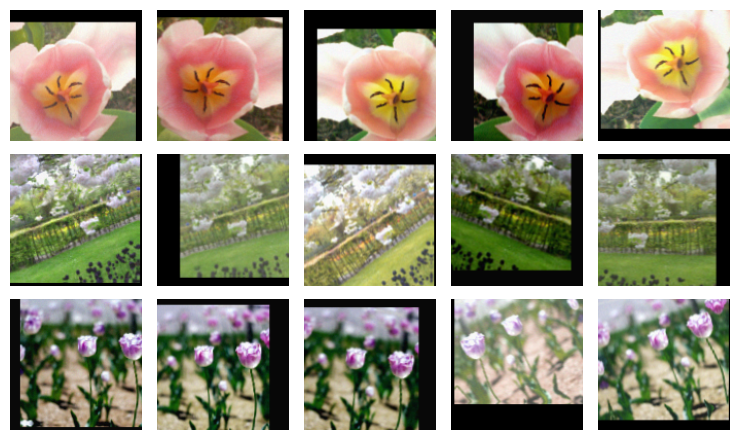

In [22]:
# initialize values
amt_images = 3 # amount of random images to pick from the dataset
amt_augments = 5 # amount of random augments to apply to each image

# pick out a random batch of images
for images, _ in train_ds.take(1):
    original_images = images

# plot augmented images
plt.figure(figsize=(amt_augments*1.5, amt_images*1.5))
for i in range(amt_images * amt_augments):
    augmented_img = data_augmentation(tf.expand_dims(original_images[i // amt_augments], 0), training=True)
    plt.subplot(amt_images, amt_augments, i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(augmented_img[0]))
    plt.axis("off")

plt.tight_layout()
plt.show()

# Custom Model

## Build Model

Creating a model from scratch  

No hyperparameter tuning is done for this model, it is used on the pretrained model later on  
Instead, we initiate this model with values that should work well based on best practices and experience  

Activation function for layers in the model is **relu**  
It outputs zero for all negative values, as such it introduces non-linearity and creates a sparse activation which can help reduce overfitting  
Has a simple gradient, and is more computationally efficient than some other activation functions  
Finally, it helps mitigate vanishing gradient problems, as values do not go below zero  

Activation function for output layer is **softmax**  
This is default for multi-class classification problem as this case  
It will output a probability for each class, with a sum of 1, the highest probability value will be the predicted class  

Optimiser is **adam**  
This is the default go-to for optimisers, it combines the benefits of momentum and RMSprop to better reach a global minima  
It has adaptive learning rates where each parameter individually has its own rate, between 0 and the initial learning rate  
Adam will tune these individual learning rates while the model trains, so it is generally not needed to have any learning rate decay, this eliminates one hyperparameter from the equation. The initial learning rate can be changed, however it is not strictly necessary  

Loss function typically uses categorical cross entropy for multi-class classification  
As the dataset was initiated with integer labels **sparse categorical cross entropy** is used, instead of the regular which uses one-hot encoded labels  

### Overfitting Model

Starting off with a small model in order for it to be as lightweight as possible, we can ensure that the model is stil complex enough to learn the data by first running it with no regularisation and seeing if it's able to overfit to the data  


In [23]:
num_classes = len(classes)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(8, 3, strides=(2, 2), padding="same", activation="relu"),
  layers.Conv2D(16, 3, strides=(2, 2), padding="same", activation="relu"),
  layers.Flatten(),
  layers.Dense(32, activation="relu"),
  layers.Dense(num_classes, activation="softmax")
])


model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10



c:\GitHub\CNN\venv\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



88/88 [==============================] - 3s 20ms/step - loss: 1.2867 - accuracy: 0.4508 - val_loss: 1.1485 - val_accuracy: 0.5105
Epoch 2/10
88/88 [==============================] - 1s 13ms/step - loss: 1.0265 - accuracy: 0.6083 - val_loss: 1.0943 - val_accuracy: 0.5597
Epoch 3/10
88/88 [==============================] - 1s 12ms/step - loss: 0.8441 - accuracy: 0.6867 - val_loss: 1.0417 - val_accuracy: 0.5793
Epoch 4/10
88/88 [==============================] - 1s 12ms/step - loss: 0.6368 - accuracy: 0.7798 - val_loss: 1.1901 - val_accuracy: 0.5560
Epoch 5/10
88/88 [==============================] - 1s 12ms/step - loss: 0.4401 - accuracy: 0.8675 - val_loss: 1.1088 - val_accuracy: 0.5916
Epoch 6/10
88/88 [==============================] - 1s 12ms/step - loss: 0.3062 - accuracy: 0.9166 - val_loss: 1.0927 - val_accuracy: 0.6027
Epoch 7/10
88/88 [==============================] - 1s 13ms/step - loss: 0.1720 - accuracy: 0.9653 - val_loss: 1.1386 - val_accuracy: 0.6101
Epoch 8/10
88/88 [=====

Defining a function to plot history

In [24]:
def history_plot(history):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Valid Acc")
    plt.legend(loc="lower right")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1])
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Valid Loss")
    plt.legend(loc="upper right")
    plt.ylabel("Loss")
    plt.ylim([min(plt.ylim()),max(plt.ylim())])
    plt.title("Training and Validation Loss")
    plt.xlabel("epoch")
    plt.show()


As seen in the history plot, training accuracy keeps increasing while validation accuracy drops off  
This is a clear sign that the model is overfitting to the training data  
As such, we have a model that is complex enough for the task

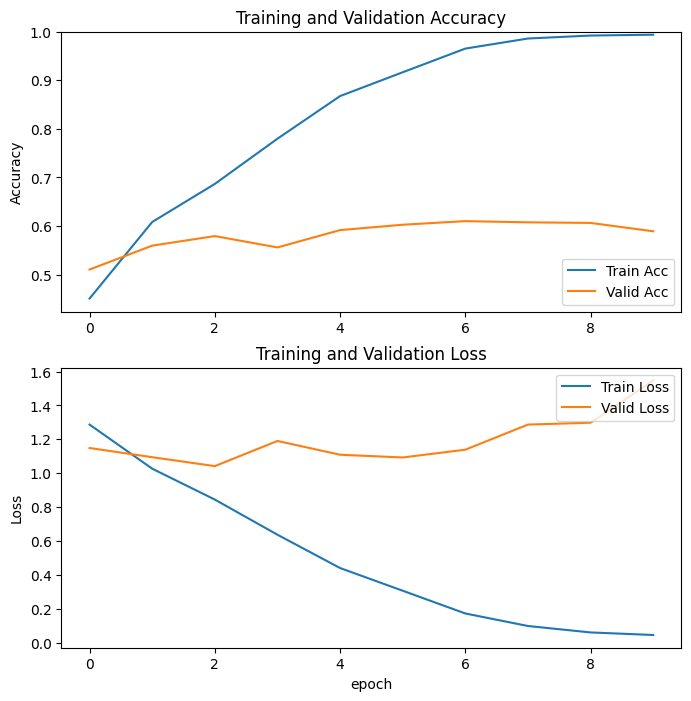

In [25]:
history_plot(history)

### Adding Regularisation

Keeping the same model architecture, we now add in regularisation steps to prevent overfitting  
Using the data augmentation layer group defined earlier  
And adding dropout layers to turn off nodes randomly during training to avoid the network relying too heavily on individual nodes

In [26]:
num_classes = len(classes)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(8, 3, strides=(2, 2), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(16, 3, strides=(2, 2), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 8)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        1168      
                                                     

### Visualize Model

Finally, this is the model architecture we end up with  
The tendency goes from larger shallow layers at the bottom, to smaller deeper layers at the top  

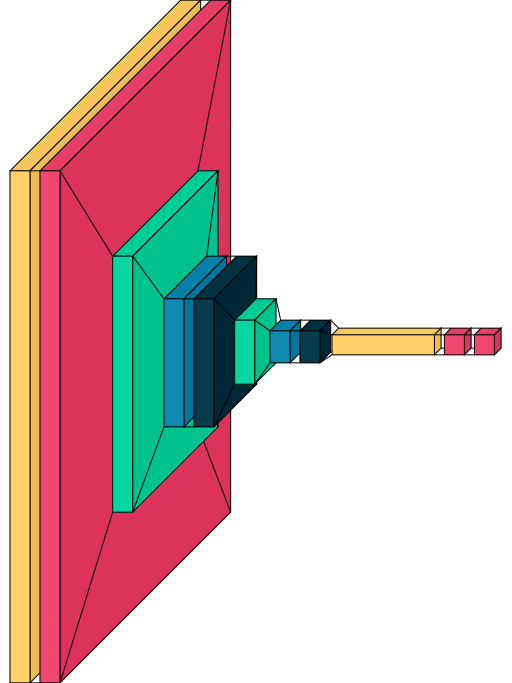

In [27]:
visualkeras.layered_view(model)

## Training

### Epochs and Early Stopping

All models will run for 500 epochs with an early_stopping callback  
This means that the model training will stop automatically whenever it is no longer improving, likely long before it reaches 500  
No improvement here is defined as val_loss not increasing for over 8 epochs  

When training is stopped, the best weights found will be retained

In [28]:
epochs=500
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

### Train the model

Fit model to training data and validate on validation data  

In [29]:
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/500
88/88 [==============================] - 5s 44ms/step - loss: 1.5606 - accuracy: 0.2603 - val_loss: 1.4851 - val_accuracy: 0.3407
Epoch 2/500
88/88 [==============================] - 4s 43ms/step - loss: 1.4607 - accuracy: 0.3473 - val_loss: 1.3987 - val_accuracy: 0.3530
Epoch 3/500
88/88 [==============================] - 4s 45ms/step - loss: 1.3048 - accuracy: 0.4447 - val_loss: 1.2423 - val_accuracy: 0.4859
Epoch 4/500
88/88 [==============================] - 4s 47ms/step - loss: 1.2653 - accuracy: 0.4608 - val_loss: 1.2056 - val_accuracy: 0.5203
Epoch 5/500
88/88 [==============================] - 4s 44ms/step - loss: 1.2116 - accuracy: 0.5009 - val_loss: 1.2376 - val_accuracy: 0.4908
Epoch 6/500
88/88 [==============================] - 4s 51ms/step - loss: 1.1726 - accuracy: 0.5159 - val_loss: 1.1526 - val_accuracy: 0.5215
Epoch 7/500
88/88 [==============================] - 5s 52ms/step - loss: 1.1582 - accuracy: 0.5313 - val_loss: 1.1743 - val_accuracy: 0.5154
Epoch 

## Evaluation

Evaluate model on test data

In [30]:
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss}, Accuracy: {accuracy}")

12/12 [==============================] - 0s 17ms/step - loss: 0.8342 - accuracy: 0.6432
Loss: 0.8342344164848328, Accuracy: 0.6432291865348816


### Accuracy and Loss Plot

Once again plotting the training history  
This time the train and val lines move more closely together and don't end up splitting apart towards the end  
The improvement drops off over time and eventually starts stagnating, at this point the early_stopping kicks in and stops the training  
The weights of the lowest val_loss are retained

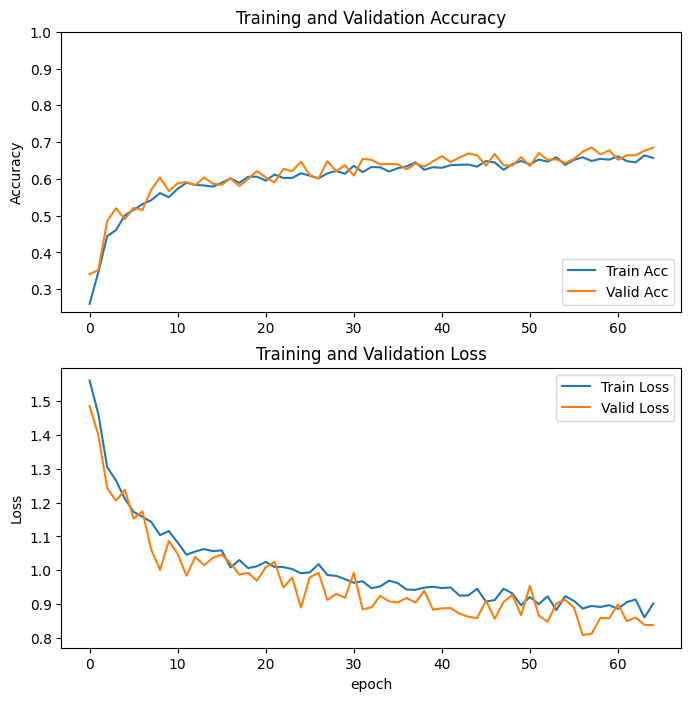

In [31]:
history_plot(history)

### Predicting on Test Data

Predict on all images and plot a couple where it predicted wrong to see where the model makes mistakes  

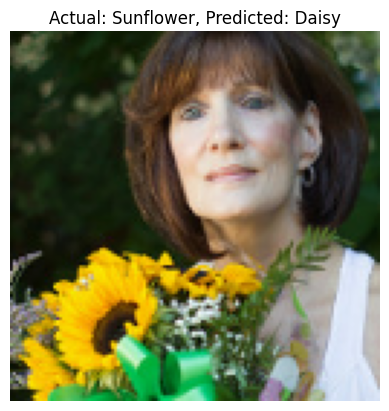

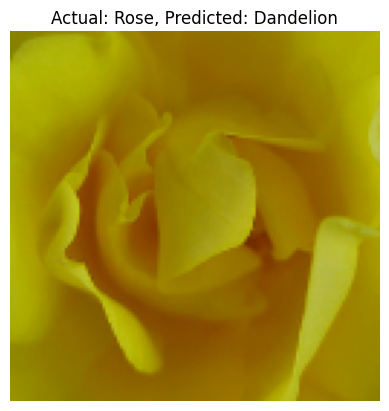

In [32]:
def get_predictions(show_wrong=False, images_to_show=1):
    test_predictions = []
    test_labels = []

    count = 0
    for images, labels in test_ds: # iterate over batches
        for image, label in zip(images, labels): # iterate over image in batch
            # make prediction and pick highest probability
            prediction = np.argmax(model.predict(tf.expand_dims(image, axis=0), verbose=False))
            test_predictions.append(prediction)
            test_labels.append(label)

            if show_wrong and prediction != label and count < images_to_show:
                count += 1

                # convert to numpy and plot image
                image_np = image.numpy().astype("uint8")
                plt.imshow(image_np)

                # set title
                true = f"Actual: {classes[label].capitalize()}"
                pred = f"Predicted: {classes[prediction].capitalize()}"
                plt.title(f"{true}, {pred}")

                plt.axis("off")
                plt.show()

    return test_predictions, test_labels

test_predictions, test_labels = get_predictions(show_wrong=True, images_to_show=2)

### Confusion Matrix

Plot a confusion matrix over model predictions vs actual labels to see which classes the model handles well and not so well  
This gives a good overview of where the model has learned the classes well, and where more training data might be needed  

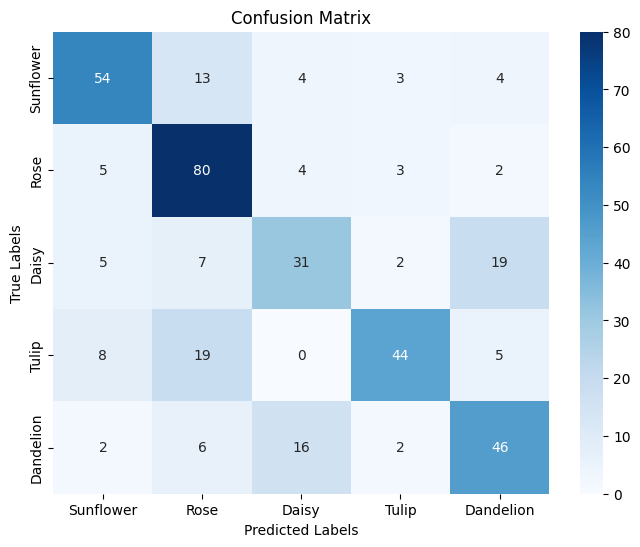

In [33]:
def get_cm():
    labels = [classes[i].capitalize() for i in test_labels]
    predictions = [classes[i].capitalize() for i in test_predictions]
    cm = confusion_matrix(labels, predictions)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(labels), yticklabels=set(labels))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

get_cm()

# Transfer Learning

## Pretrained Model

**Mobilenet** is the model chosen for transfer learning, it is a smaller and faster model well suited for running on a slower laptop  
It is trained on a relatively similar dataset in imagenet with 1000 classes  
Some of the classes it's trained on are flowers and plants, so it should already be able to detect shapes that identify plants, so it provides a good starting step for learning to distinguish the different types we have here  

## Feature Extraction vs Fine Tuning

Chosing which method to use depends on a few factors  

Feature Extraction is used when:
 - Small dataset  
 - Low computational power  
 - Similar data to pretrained dataset  

Fine Tuning is used when:
 - Large dataset  
 - High computational power  
 - Different data to pretrained dataset  

This case follows all the points under feature extraction, as such, **feature extraction** is the method that will be used  

## Initialize Model

### Original Model  

Initialize the entire pretrained model including top in order to look at the architecture  


In [34]:
input_shape = (*image_size, 3)
model_original = MobileNet(weights='imagenet', include_top=True, input_shape=input_shape)
model_original.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32) 

### Without Top

Initialize the model without top (classification) layers  
This is done so we can replace the classification layers with new ones suited to our classification task, and retrain them  
The model layers are frozen so that only new added layers will be trained

In [35]:
# load pretrained model without top
model_pretrained = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
model_pretrained.trainable = False # freeze all convolutional layers
model_pretrained.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32) 

## Hyperparameter Tuning

### Model Builder Function

First layers take input, augment data, and scale values between -1 to 1  
Add the pretrained model  
Recreate identical layers to original top of pretrained model to keep the same proven architecture  
Add 2 dense layers at the end, one to train to learn the data, and the other as output layer  

Hyperparameter tuning is added for dropout, learning rate, and size of dense layer  
No hyperparameter tuning is done for values already motivated, or values used in the original model as they have been proven to work well  
This approach greatly reduces the time to tune hyperparameters while we can be confident in getting good results

In [36]:
def model_builder(hp):
  inputs = keras.Input(shape=(*image_size, 3), batch_size=batch_size)
  x = data_augmentation(inputs)

  # rescale to -1 to 1 as mobilenet expects this range
  x = keras.layers.Rescaling(1./127.5, offset=-1)(x)

  # mobilenet model without top
  x = model_pretrained(x, training=False) # pretrained model (without top)

  # recreate same architecture as original top but replace 2D conv with dense layer
  x = keras.layers.GlobalAveragePooling2D()(x)
  # hyperparam tuning of last dropout
  hp_dropout = hp.Float("dropout", min_value=0.1, max_value=0.3, step=0.1)
  x = keras.layers.Dropout(hp_dropout)(x)
  # hyperparam tuning of dense layer
  hp_dense = hp.Int("dense", min_value=32, max_value=128, step=32)
  x = keras.layers.Dense(hp_dense)(x)
  outputs = keras.layers.Dense(5, activation="softmax")(x) # output layer (amt classes)

  model = keras.Model(inputs, outputs)

  # hyperparam tuning of learning rate (ceiling due to adam)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
  )

  return model

### Tuner Setup

Using hyperband as tuner because it is much less extensive than grid search while still providing good comparisons of hyperparameters  
Once again this is done to greatly reduce time to tune while still giving close-to optimal values for hyperparameters tuned

In [37]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    project_name="hyperparameter_tuning",
    seed=42
)

tuner.search(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Trial 23 Complete [00h 00m 34s]
val_accuracy: 0.8831488490104675

Best val_accuracy So Far: 0.892988920211792
Total elapsed time: 00h 13m 02s


## Build Model

Using the best found hyperparameters to build the final model

In [38]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 128, 128, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (32, 128, 128, 3)         0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (32, 1024)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (32, 1024)                0   

## Training

### Combine Datasets

Train and val data can now be combined to create a larger dataset for training  
This is done because val has served its purpose in hyperparameter tuning and now has to be considered "seen" data  
Final validations are instead done on entirely unseen data in the test dataset

In [39]:
combined_ds = train_ds.concatenate(val_ds)

### Train Model

Train on the combined dataset and validate on test dataset

In [40]:
history = model.fit(
    combined_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[early_stopping]
)

Epoch 1/500
114/114 [==============================] - 19s 148ms/step - loss: 1.3582 - accuracy: 0.7366 - val_loss: 0.5134 - val_accuracy: 0.8177
Epoch 2/500
114/114 [==============================] - 16s 144ms/step - loss: 0.4917 - accuracy: 0.8225 - val_loss: 0.3323 - val_accuracy: 0.8646
Epoch 3/500
114/114 [==============================] - 16s 145ms/step - loss: 0.4189 - accuracy: 0.8530 - val_loss: 0.4080 - val_accuracy: 0.8646
Epoch 4/500
114/114 [==============================] - 17s 148ms/step - loss: 0.4240 - accuracy: 0.8530 - val_loss: 0.4913 - val_accuracy: 0.8464
Epoch 5/500
114/114 [==============================] - 18s 155ms/step - loss: 0.4212 - accuracy: 0.8469 - val_loss: 0.4186 - val_accuracy: 0.8542
Epoch 6/500
114/114 [==============================] - 16s 142ms/step - loss: 0.4252 - accuracy: 0.8514 - val_loss: 0.5094 - val_accuracy: 0.8333
Epoch 7/500
114/114 [==============================] - 17s 148ms/step - loss: 0.4974 - accuracy: 0.8308 - val_loss: 0.5324 -

## Evaluation

In [41]:
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss}, Accuracy: {accuracy}")

12/12 [==============================] - 2s 110ms/step - loss: 0.3398 - accuracy: 0.8620
Loss: 0.3397986888885498, Accuracy: 0.8619791865348816


### Accuracy and Loss Plot

Once again plotting the training history  
This time the train and val lines move more closely together and don't end up splitting apart towards the end  
The improvement drops off over time and eventually starts stagnating, at this point the early_stopping kicks in and stops the training  
The weights of the lowest val_loss are retained

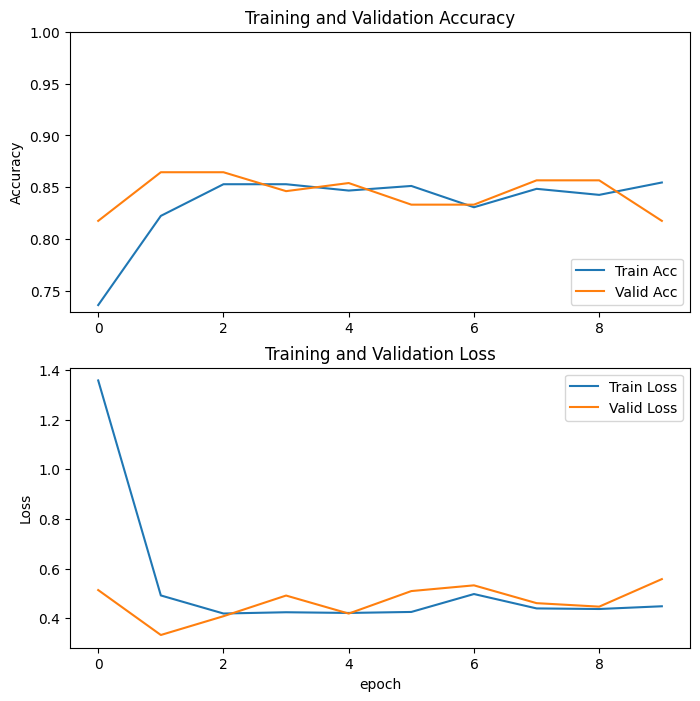

In [42]:
history_plot(history)

### Predicting on Test Data

Predict on all images and plot a couple where it predicted wrong to see where the model makes mistakes  

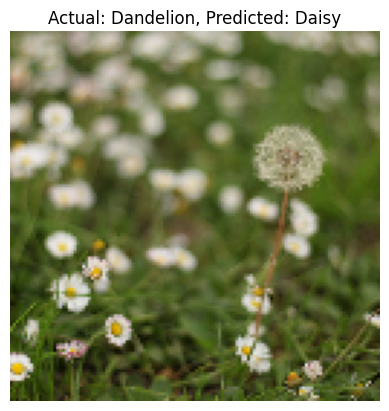

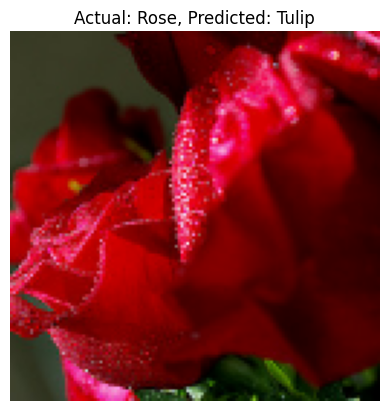

In [43]:
test_predictions, test_labels = get_predictions(show_wrong=True, images_to_show=2)

### Confusion Matrix

Once again plot a confusion matrix over model predictions vs actual labels to see which classes the model handles well and not so well  
This gives a good overview of where the model has learned the classes well, and where more training data might be needed  

This time around the model has learned the classes much better

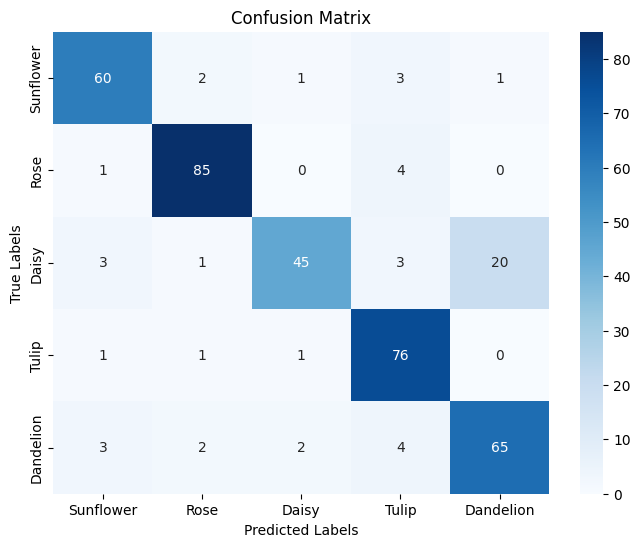

In [44]:
get_cm()

# Conclusion

Custom model around 65% accuracy  
Pretrained model with transfer learning around 80% accuracy  

Considering models were chosen for being fast and lightweight, the results are not bad, especially on the pretrained model  
Custom model had problems with mislabeling certain classes which caused accuracy to drop a lot  

Specific improvements on custom model:  
- Adding hyperparameter tuning  
- Add more data for classes model had problems with  

Some general improvements could be:  
- More data to train on  
- More data augmentation, for more data and better generalization 
- Other types of regularisation  
- Tuning more hyperparameters, using randomsearch to reduce time to tune as amount of hyperparameters tuned grows  
